In [1]:
import os

import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Assemble all JSON files into a single dataframe
RADEON = 'Radeon RX 6800 XT'
XAVIER = 'Xavier NX'

directories = [
    {'device': RADEON, 'path': os.path.join('..','measurements','20241230-121631139-amd') },
    {'device': XAVIER, 'path': os.path.join('..', '..', '03', 'measurements', '20241230-121548185') }
]

jsonData = []
for entry in directories:
    device = entry['device']
    jsonDirectory = entry['path']
    for filename in os.listdir(jsonDirectory):
        if not filename.endswith('.json'):
            continue
        filePath = os.path.join(jsonDirectory, filename)
        if not os.path.isfile(filePath):
            continue

        with open(filePath, 'r', encoding='utf-8') as file:
            data = json.load(file)
            jsonData.append({
                'device': device,
                'key': os.path.splitext(os.path.basename(filePath))[0],
                'data': data
            })

# Now jsonData is a list of records.

In [3]:
# Create a single Pandas dataframe from the list of records.
def createDfAll():
    def createDataframe(
        sourceKey,
        device,
        kernelKey,
        mappingLetter,
        uniformInput,
        inputFileName,
        inputLengthInCharacters,
        timesTransferToDevice,
        timesExecution,
        timesTransferFromDevice,
        bins
    ):
        n = len(timesExecution)
        df = pd.DataFrame({
            'sourceKey': [sourceKey] * n,
            'device': [device] * n,
            'kernel': [kernelKey] * n,
            'mappingLetter': [mappingLetter] * n,
            'uniformInput': [uniformInput] * n,
            'inputFileName': [inputFileName] * n,
            'inputLengthInCharacters': [inputLengthInCharacters] * n,
            'timeTransferToDevice': timesTransferToDevice,
            'timeExecution': timesExecution,
            'timeTransferFromDevice': timesTransferFromDevice,
            'timeTotal': None,
            'bins': [bins] * n
        })
        df['timeTotal'] = df['timeTransferToDevice'] + df['timeExecution'] + df['timeTransferFromDevice']
        return df

    dfs = []
    for entry in jsonData:
        device = entry['device']
        sourceKey = entry['key']
        rec = entry['data']
        inputLengthInCharacters = rec['inputLengthInCharacters']
        inputFileName = rec.get('fileName')
        uniformInput = rec['uniformInput']
        mappingLetter = rec['useMappingLetter']
        for k in rec['measurements'].keys():
            measurements = rec['measurements'][k]
            dfs.append(createDataframe(
                sourceKey,
                device,
                k,
                mappingLetter,
                uniformInput,
                inputFileName,
                inputLengthInCharacters,
                measurements['timesTransferToDevice'],
                measurements['timesExecution'],
                measurements['timesTransferFromDevice'],
                measurements['bins']
            ))
    return pd.concat(dfs)
dfAll = createDfAll()

In [4]:
dfAll.head()

,sourceKey,device,kernel,mappingLetter,uniformInput,inputFileName,inputLengthInCharacters,timeTransferToDevice,timeExecution,timeTransferFromDevice,timeTotal,bins
0,20241230-121631139-000,Radeon RX 6800 XT,histogram_atomic_global,False,False,./input_data/test.txt,10532866,2.323308,1.043039,0.383493,3.749840,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
1,20241230-121631139-000,Radeon RX 6800 XT,histogram_atomic_global,False,False,./input_data/test.txt,10532866,0.773336,1.041129,0.018960,1.833425,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
2,20241230-121631139-000,Radeon RX 6800 XT,histogram_atomic_global,False,False,./input_data/test.txt,10532866,0.793047,1.043008,0.019560,1.855615,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
3,20241230-121631139-000,Radeon RX 6800 XT,histogram_atomic_global,False,False,./input_data/test.txt,10532866,0.656135,1.043929,0.020080,1.720144,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
4,20241230-121631139-000,Radeon RX 6800 XT,histogram_atomic_global,False,False,./input_data/test.txt,10532866,0.771796,1.049229,0.020000,1.841025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."


In [5]:
def getMeasurementsFor(
    df,
    device,
    mapping,
    inputType,
    kernels = None
):
    boolDevice = df['device'] == device
    if kernels is None:
        boolKernel = [True] * len(df['kernel'])
    else:
        if not isinstance(kernel, list):
            kernels = [kernels]
        boolKernel = df['kernel'].isin(kernels)
    if mapping == 'Mapping128':
        boolMapping = (df['mappingLetter'] == False)
    elif mapping == 'MappingLetter':
        boolMapping = (df['mappingLetter'] == True)
    else:
        raise RuntimeError('invalid mapping')
    if inputType == 'testfile':
        boolInputType = (df['inputFileName'].notna())
    elif inputType == 'uniform':
        boolInputType = (df['uniformInput'] == True) * (df['inputFileName'].isna())
    elif inputType == 'pseudorandom':
        boolInputType = (df['uniformInput'] == False) * (df['inputFileName'].isna())
    else:
        raise RuntimeError('invalid inputType')
    return df[boolDevice * boolKernel * boolMapping * boolInputType]

In [6]:
getMeasurementsFor(dfAll, RADEON, 'Mapping128', 'testfile', kernels=None)

,sourceKey,device,kernel,mappingLetter,uniformInput,inputFileName,inputLengthInCharacters,timeTransferToDevice,timeExecution,timeTransferFromDevice,timeTotal,bins
0,20241230-121631139-000,Radeon RX 6800 XT,histogram_atomic_global,False,False,./input_data/test.txt,10532866,2.323308,1.043039,0.383493,3.749840,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
1,20241230-121631139-000,Radeon RX 6800 XT,histogram_atomic_global,False,False,./input_data/test.txt,10532866,0.773336,1.041129,0.018960,1.833425,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
2,20241230-121631139-000,Radeon RX 6800 XT,histogram_atomic_global,False,False,./input_data/test.txt,10532866,0.793047,1.043008,0.019560,1.855615,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
3,20241230-121631139-000,Radeon RX 6800 XT,histogram_atomic_global,False,False,./input_data/test.txt,10532866,0.656135,1.043929,0.020080,1.720144,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
4,20241230-121631139-000,Radeon RX 6800 XT,histogram_atomic_global,False,False,./input_data/test.txt,10532866,0.771796,1.049229,0.020000,1.841025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
95,20241230-121631139-000,Radeon RX 6800 XT,histogram_atomic_global_stride,False,False,./input_data/test.txt,10532866,0.694176,1.046018,0.024550,1.764744,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
96,20241230-121631139-000,Radeon RX 6800 XT,histogram_atomic_global_stride,False,False,./input_data/test.txt,10532866,0.656465,1.051878,0.020320,1.728663,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
97,20241230-121631139-000,Radeon RX 6800 XT,histogram_atomic_global_stride,False,False,./input_data/test.txt,10532866,0.654885,1.052138,0.023821,1.730844,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."
98,20241230-121631139-000,Radeon RX 6800 XT,histogram_atomic_global_stride,False,False,./input_data/test.txt,10532866,0.655405,1.052438,0.023090,1.730933,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 37022, 0, 0, 0, 0,..."


## Measurement results for test input file

In [7]:
dfTestFile = dfAll[dfAll['inputFileName'].notna()]

Number of characters in the test input file:

In [8]:
s = set(dfTestFile['inputLengthInCharacters'])
if len(s) != 1:
    raise RuntimeError('Something is wrong')
list(s)[0]

10532866

Distribution of characters in the test input file (bin counts under `Mapping128`):

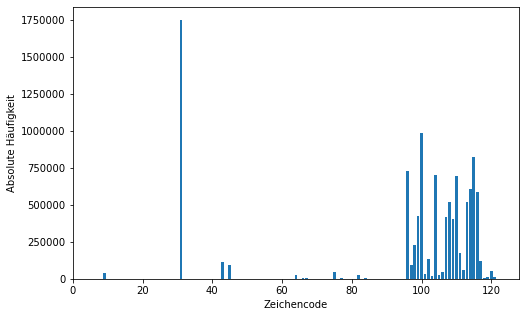

In [9]:
binCounts = dfTestFile.iloc[0]['bins']

fig = plt.figure(figsize=(8,5))
plt.bar(list(range(0,len(binCounts))), binCounts)
plt.xlim(0, len(binCounts))
fig.axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.xlabel('Zeichencode')
plt.ylabel('Absolute Häufigkeit')
plt.show()

TODO (evtl.): Tabelle mit den Häufigkeiten der einzelnen Zeichen

Statistik:

In [10]:
def testFileMakeStatistics(mapping):
    if mapping == 'Mapping128':
        boolMapping = dfTestFile['mappingLetter'] == False
    elif mapping == 'MappingLetter':
        boolMapping = dfTestFile['mappingLetter'] == True
    return dfTestFile[boolMapping].groupby(['device', 'kernel'])[
        ['timeTransferToDevice', 'timeExecution', 'timeTransferFromDevice', 'timeTotal']
    ].agg([
        ('min', lambda x: x.min()),
        ('q10', lambda x: x.quantile(0.1)),
        ('med', lambda x: x.median()),
        ('q90', lambda x: x.quantile(0.5)),
        ('max', lambda x: x.max())
    ])

In [11]:
stat128 = testFileMakeStatistics('Mapping128')
stat128

timeTransferToDevice  \
                                                                   min   
device            kernel                                                 
Radeon RX 6800 XT histogram_atomic_global                     0.649614   
                  histogram_atomic_global_stride              0.647145   
                  histogram_atomic_private                    0.649685   
                  histogram_atomic_private_stride             0.644125   
Xavier NX         histogram_atomic_global                     1.818048   
                  histogram_atomic_global_stride              1.805984   
                  histogram_atomic_private                    1.616832   
                  histogram_atomic_private_stride             1.383744   

                                                                       \
                                                        q10       med   
device            kernel                                                
Radeon RX 6800 XT histogram_atomic_global          0.651382  0.668305   
                  histogram_atomic_global_stride   0.650891  0.670130   
                  histogram_atomic_private         0.652638  0.673351   
                  histogram_atomic_private_stride  0.652105  0.656340   
Xavier NX         histogram_atomic_global          1.840858  1.942304   
                  histogram_atomic_global_stride   1.874573  1.983040   
                  histogram_atomic_private         1.889114  2.030176   
                  histogram_atomic_private_stride  1.450490  1.634784   

                                                                       \
                                                        q90       max   
device            kernel                                                
Radeon RX 6800 XT histogram_atomic_global          0.668305  2.323308   
                  histogram_atomic_global_stride   0.670130  1.658591   
                  histogram_atomic_private         0.673351  1.659642   
                  histogram_atomic_private_stride  0.656340  1.665622   
Xavier NX         histogram_atomic_global          1.942304  2.423968   
                  histogram_atomic_global_stride   1.983040  2.194240   
                  histogram_atomic_private         2.030176  2.675840   
                  histogram_atomic_private_stride  1.634784  2.300384   

                                                  timeExecution            \
                                                            min       q10   
device            kernel                                                    
Radeon RX 6800 XT histogram_atomic_global              1.041129  1.042815   
                  histogram_atomic_global_stride       1.044118  1.046307   
                  histogram_atomic_private             0.112881  0.114441   
                  histogram_atomic_private_stride      0.062881  0.066304   
Xavier NX         histogram_atomic_global              9.502528  9.571648   
                  histogram_atomic_global_stride       9.546272  9.573888   
                  histogram_atomic_private             2.018624  2.065830   
                  histogram_atomic_private_stride      1.015968  1.032304   

                                                                       \
                                                        med       q90   
device            kernel                                                
Radeon RX 6800 XT histogram_atomic_global          1.043188  1.043188   
                  histogram_atomic_global_stride   1.049358  1.049358   
                  histogram_atomic_private         0.115721  0.115721   
                  histogram_atomic_private_stride  0.067866  0.067866   
Xavier NX         histogram_atomic_global          9.810208  9.810208   
                  histogram_atomic_global_stride   9.610128  9.610128   
                  histogram_atomic_private         2.121568  2.121568   
                  histogram_atomic_private_stride

In [12]:
statLetter = testFileMakeStatistics('MappingLetter')
statLetter

timeTransferToDevice  \
                                                                   min   
device            kernel                                                 
Radeon RX 6800 XT histogram_atomic_global                     0.749202   
                  histogram_atomic_global_stride              0.780336   
                  histogram_atomic_private                    0.777806   
                  histogram_atomic_private_stride             0.776396   
Xavier NX         histogram_atomic_global                     1.830016   
                  histogram_atomic_global_stride              1.825216   
                  histogram_atomic_private                    1.555552   
                  histogram_atomic_private_stride             1.413312   

                                                                       \
                                                        q10       med   
device            kernel                                                
Radeon RX 6800 XT histogram_atomic_global          0.782010  0.797524   
                  histogram_atomic_global_stride   0.783291  0.797316   
                  histogram_atomic_private         0.779324  0.782441   
                  histogram_atomic_private_stride  0.779821  0.782626   
Xavier NX         histogram_atomic_global          1.896022  2.011648   
                  histogram_atomic_global_stride   1.880208  1.963968   
                  histogram_atomic_private         1.787917  2.017136   
                  histogram_atomic_private_stride  1.490861  1.640544   

                                                                       \
                                                        q90       max   
device            kernel                                                
Radeon RX 6800 XT histogram_atomic_global          0.797524  2.120575   
                  histogram_atomic_global_stride   0.797316  1.695992   
                  histogram_atomic_private         0.782441  1.683943   
                  histogram_atomic_private_stride  0.782626  1.681473   
Xavier NX         histogram_atomic_global          2.011648  2.390144   
                  histogram_atomic_global_stride   1.963968  2.193440   
                  histogram_atomic_private         2.017136  2.525920   
                  histogram_atomic_private_stride  1.640544  2.385184   

                                                  timeExecution             \
                                                            min        q10   
device            kernel                                                     
Radeon RX 6800 XT histogram_atomic_global              1.281170   1.282987   
                  histogram_atomic_global_stride       1.283589   1.284903   
                  histogram_atomic_private             0.116841   0.118468   
                  histogram_atomic_private_stride      0.068790   0.071948   
Xavier NX         histogram_atomic_global             11.276736  11.290499   
                  histogram_atomic_global_stride      11.311840  11.334416   
                  histogram_atomic_private             2.057600   2.095552   
                  histogram_atomic_private_stride      1.067552   1.105882   

                                                                         \
                                                         med        q90   
device            kernel                                                  
Radeon RX 6800 XT histogram_atomic_global           1.283456   1.283456   
                  histogram_atomic_global_stride    1.287594   1.287594   
                  histogram_atomic_private          0.119196   0.119196   
                  histogram_atomic_private_stride   0.072605   0.072605   
Xavier NX         histogram_atomic_global          11.323952  11.323952   
                  histogram_atomic_global_stride   11.370896  11.370896   
                  histogram_atomic_private          2.142864   2.142864   
                  

Ausführungszeiten für die einzelnen Kernels für die beiden Mappings:

In [13]:
data1 = stat128['timeExecution']['med']
data2 = statLetter['timeExecution']['med']

data1.index = pd.MultiIndex.from_tuples([(x, 'Mapping128', z) for x, z in data1.index], names=['device', 'mapping', 'kernel'])
data2.index = pd.MultiIndex.from_tuples([(x, 'MappingLetter', z) for x, z in data2.index], names=['device', 'mapping', 'kernel'])
s = pd.concat([data1, data2]).sort_index(level=0).unstack(level=1).unstack(level=1)
s

mapping                        Mapping128                                 \
kernel            histogram_atomic_global histogram_atomic_global_stride   
device                                                                     
Radeon RX 6800 XT                1.043188                       1.049358   
Xavier NX                        9.810208                       9.610128   

mapping                                                                     \
kernel            histogram_atomic_private histogram_atomic_private_stride   
device                                                                       
Radeon RX 6800 XT                 0.115721                        0.067866   
Xavier NX                         2.121568                        1.080192   

mapping                     MappingLetter                                 \
kernel            histogram_atomic_global histogram_atomic_global_stride   
device                                                                     
Radeon RX 6800 XT                1.283456                       1.287594   
Xavier NX                       11.323952                      11.370896   

mapping                                                                     
kernel            histogram_atomic_private histogram_atomic_private_stride  
device                                                                      
Radeon RX 6800 XT                 0.119196                        0.072605  
Xavier NX                         2.142864                        1.168880

Speedup in den Ausführungszeiten:

In [15]:
OTPC = 'histogram_atomic_global'
dd = s.copy() # probably inefficient way of copying the layout of the dataframe
for m in set(s.columns.get_level_values(0)):
    n = s[(m, OTPC)]
    for h in set(s.columns.get_level_values(1)):
        dd[(m, h)] = n / s[(m, h)]
dd

mapping                        Mapping128                                 \
kernel            histogram_atomic_global histogram_atomic_global_stride   
device                                                                     
Radeon RX 6800 XT                     1.0                       0.994121   
Xavier NX                             1.0                       1.020820   

mapping                                                                     \
kernel            histogram_atomic_private histogram_atomic_private_stride   
device                                                                       
Radeon RX 6800 XT                 9.014686                       15.371298   
Xavier NX                         4.624036                        9.081911   

mapping                     MappingLetter                                 \
kernel            histogram_atomic_global histogram_atomic_global_stride   
device                                                                     
Radeon RX 6800 XT                     1.0                       0.996785   
Xavier NX                             1.0                       0.995872   

mapping                                                                     
kernel            histogram_atomic_private histogram_atomic_private_stride  
device                                                                      
Radeon RX 6800 XT                10.767605                       17.677233  
Xavier NX                         5.284494                        9.687865

Untersuchung der Transferzeiten auf das Device:

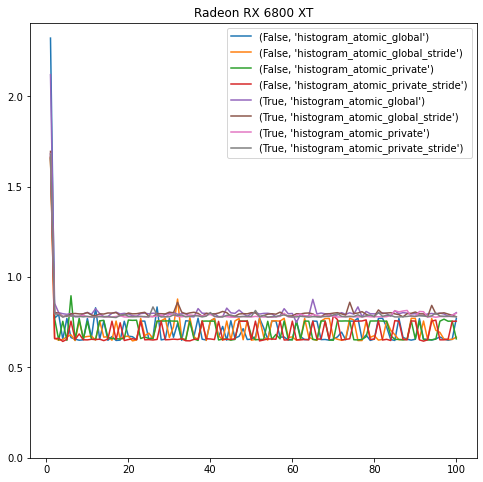

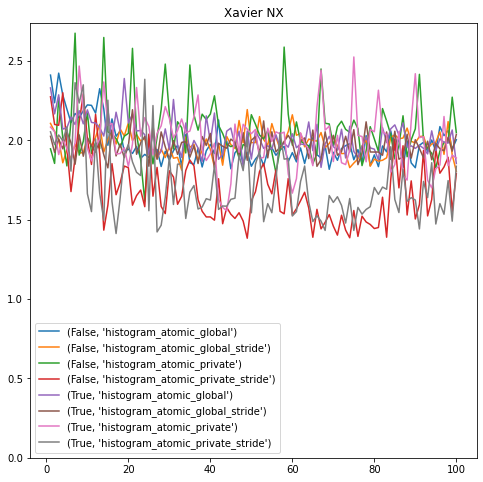

In [16]:
for device, grp in dfTestFile.groupby(['device']):
    plt.subplots(figsize=(8,8))
    plt.title(device)
    grouped = grp.groupby(['mappingLetter', 'kernel'])
    for name, group in grouped:
        c = group['timeTransferToDevice']
        plt.plot(range(1,len(c)+1),c, label=name)
    plt.ylim(0)
    plt.legend()
    plt.show()

In [266]:
# Analyse execution times

dfFiltered = df[df['itemMeasured'] == 'timesExecution']
grouped = dfFiltered.groupby('kernel')

def scatterPlotForGroup(groupName):
    ddf = grouped.get_group(groupName)
    
    plt.figure(figsize=(4,3))
    plt.scatter(ddf['inputLengthInCharacters'], ddf['time'], s=3)
    plt.xscale('log', base=2)
    plt.yscale('log', base=10)
    plt.show()

scatterPlotForGroup('histogram_one_thread_per_character')

KeyError: 'itemMeasured'

In [5]:
def statisticsForGroup(groupName):
    ddf = grouped.get_group(groupName)
    
    return ddf.groupby('inputLengthInCharacters')['time'].agg(
        average='mean',
        std_dev='std',
        min='min',
        max='max',
        first_decile=lambda x: x.quantile(0.1),
        last_decile=lambda x: x.quantile(0.9),
        median=lambda x: x.quantile(0.5)
    ).reset_index()

statistics = statisticsForGroup('histogram_one_thread_per_character')

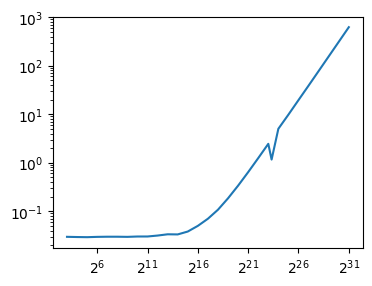

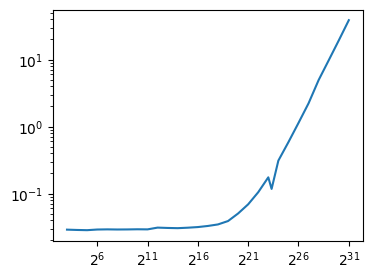

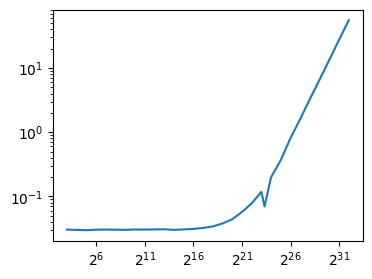

In [6]:
def lineGraphForGroup(groupName):
    statistics = statisticsForGroup(groupName)
    
    plt.figure(figsize=(4,3))
    plt.plot(statistics['inputLengthInCharacters'], statistics['average'])
    plt.xscale('log', base=2)
    plt.yscale('log', base=10)
    plt.show()

lineGraphForGroup('histogram_one_thread_per_character')
lineGraphForGroup('histogram_atomic_private')
lineGraphForGroup('histogram_atomic_private_stride')

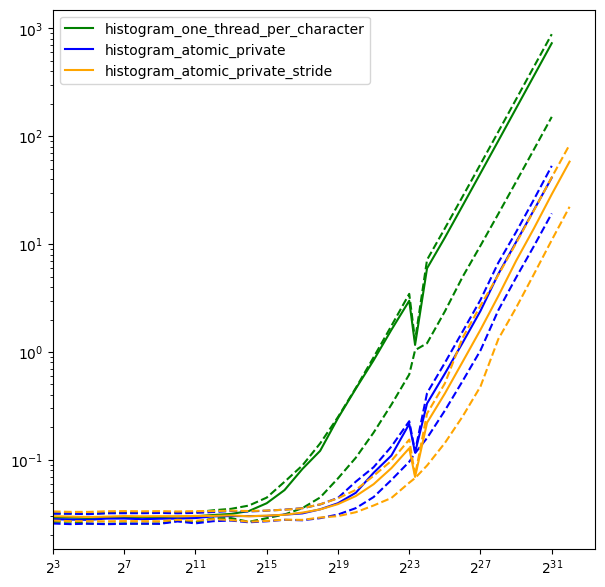

In [7]:
def lineGraphForAll():
    kernelNames = ['histogram_one_thread_per_character', 'histogram_atomic_private', 'histogram_atomic_private_stride']
    col = {
        'histogram_one_thread_per_character': 'green',
        'histogram_atomic_private': 'blue',
        'histogram_atomic_private_stride': 'orange'
    }
    s = {}
    for k in kernelNames:
        s[k] = statisticsForGroup(k)

    plt.figure(figsize=(7,7))
    for k in kernelNames:
        plt.plot(s[k]['inputLengthInCharacters'], s[k]['last_decile'], color=col[k], linestyle='--')
        plt.plot(s[k]['inputLengthInCharacters'], s[k]['median'], label=k, color=col[k])
        plt.plot(s[k]['inputLengthInCharacters'], s[k]['first_decile'], color=col[k], linestyle='--')
    plt.xscale('log', base=2)
    plt.yscale('log', base=10)
    plt.xlim(2 ** 3)
    plt.legend()
    plt.show()

lineGraphForAll()

In [8]:
df[(df['kernel'] == 'histogram_atomic_private') * (df['inputLengthInCharacters'] == 2**22) * (df['itemMeasured'] == 'timesExecution')]

,inputLengthInCharacters,kernel,itemMeasured,time
0,4194304,histogram_atomic_private,timesExecution,0.850688
1,4194304,histogram_atomic_private,timesExecution,0.824896
2,4194304,histogram_atomic_private,timesExecution,0.832672
3,4194304,histogram_atomic_private,timesExecution,0.862944
4,4194304,histogram_atomic_private,timesExecution,0.822208
...,...,...,...,...
95,4194304,histogram_atomic_private,timesExecution,0.818976
96,4194304,histogram_atomic_private,timesExecution,0.843648
97,4194304,histogram_atomic_private,timesExecution,0.869280
98,4194304,histogram_atomic_private,timesExecution,0.820960


In [9]:
df

,inputLengthInCharacters,kernel,itemMeasured,time
0,4096,histogram_one_thread_per_character,timesTransferToDevice,0.100480
1,4096,histogram_one_thread_per_character,timesTransferToDevice,0.053280
2,4096,histogram_one_thread_per_character,timesTransferToDevice,0.047744
3,4096,histogram_one_thread_per_character,timesTransferToDevice,0.165760
4,4096,histogram_one_thread_per_character,timesTransferToDevice,0.046816
...,...,...,...,...
95,16,histogram_atomic_private_stride,timesTransferFromDevice,0.039200
96,16,histogram_atomic_private_stride,timesTransferFromDevice,0.038720
97,16,histogram_atomic_private_stride,timesTransferFromDevice,0.086048
98,16,histogram_atomic_private_stride,timesTransferFromDevice,0.075712


## Measurement results for generated data

In [17]:
dfGenerated = dfAll[dfAll['inputFileName'].isna()]

Distribution of characters for input size of 2^30 (= 1 GiB):

In [18]:
counts = dfGenerated[
    (dfGenerated['inputLengthInCharacters']==2**30) *
    (dfGenerated['uniformInput'] == False)
]['bins'].iloc[0]
print('rel. dev. ', (max(counts) - min(counts)) / sum(counts))

rel. dev.  9.28528606891632e-06


In [19]:
def generatedMakeStatistics(mapping):
    if mapping == 'Mapping128':
        boolMapping = dfGenerated['mappingLetter'] == False
    elif mapping == 'MappingLetter':
        boolMapping = dfGenerated['mappingLetter'] == True
    else:
        raise RuntimeError('Invalid parameter value: mapping')
    #boolUniform = dfGenerated['uniformInput'] == uniform
    return dfGenerated[
        boolMapping #* boolUniform
    ].groupby(['device', 'uniformInput', 'inputLengthInCharacters', 'kernel'])[
        ['timeTransferToDevice', 'timeExecution', 'timeTransferFromDevice', 'timeTotal']
    ].agg([
        ('min', lambda x: x.min()),
        ('q10', lambda x: x.quantile(0.1)),
        ('med', lambda x: x.median()),
        ('q90', lambda x: x.quantile(0.5)),
        ('max', lambda x: x.max())
    ])

In [20]:
genStat = generatedMakeStatistics('Mapping128')
genStat

timeTransferToDevice  \
                                                                                                        min   
device            uniformInput inputLengthInCharacters kernel                                                 
Radeon RX 6800 XT False        8                       histogram_atomic_global                     0.021600   
                                                       histogram_atomic_global_stride              0.020840   
                                                       histogram_atomic_private                    0.016560   
                                                       histogram_atomic_private_stride             0.017960   
                               16                      histogram_atomic_global                     0.019360   
...                                                                                                     ...   
Xavier NX         True         2147483648              histogram_atomic_global_stride            278.249817   
                                                       histogram_atomic_private                  279.146881   
                                                       histogram_atomic_private_stride           278.935150   
                               4294967296              histogram_atomic_global_stride            560.186584   
                                                       histogram_atomic_private_stride           561.054443   

                                                                                                    \
                                                                                               q10   
device            uniformInput inputLengthInCharacters kernel                                        
Radeon RX 6800 XT False        8                       histogram_atomic_global            0.023313   
                                                       histogram_atomic_global_stride     0.022690   
                                                       histogram_atomic_private           0.022912   
                                                       histogram_atomic_private_stride    0.021769   
                               16                      histogram_atomic_global            0.022369   
...                                                                                            ...   
Xavier NX         True         2147483648              histogram_atomic_global_stride   278.856805   
                                                       histogram_atomic_private         279.566797   
                                                       histogram_atomic_private_stride  279.484976   
                               4294967296              histogram_atomic_global_stride   561.419287   
                                                       histogram_atomic_private_stride  561.638239   

                                                                                                    \
                                                                                               med   
device            uniformInput inputLengthInCharacters kernel                                        
Radeon RX 6800 XT False        8                       histogram_atomic_global            0.025395   
                                                       histogram_atomic_global_stride     0.024775   
                                                       histogram_atomic_private           0.024691   
                                                       histogram_atomic_private_stride    0.024626   
                               16                      histogram_atomic_global            0.024600   
...                                                                                            ...   
Xavier NX         True         2147483648              histogram_atomic_global_stride   279.500626   
                                                       histogram_atomic_private    

In [29]:
def generatedCreatePlots(genState):
    grouped = genStat.reset_index().groupby('device')

    col = {
        (False, 'histogram_atomic_global'): 'green',
        (True, 'histogram_atomic_global'): 'darkgreen',
        (False, 'histogram_atomic_private'): 'blue',
        (True, 'histogram_atomic_private'): 'darkblue',
        (False, 'histogram_atomic_private_stride'): 'orange',
        (True, 'histogram_atomic_private_stride'): 'darkorange',
        (False, 'histogram_atomic_global_stride'): 'brown',
        (True, 'histogram_atomic_global_stride'): 'black',
    }

    for device, grp in grouped:
        plt.figure(figsize=(7,7))
        by_kernel = grp.groupby(['uniformInput', 'kernel'])
        for (uniform, kernel), g in by_kernel:
            plt.plot(g['inputLengthInCharacters'], g[('timeExecution', 'q10')], color=col[(uniform, kernel)], linestyle='--')
            plt.plot(g['inputLengthInCharacters'], g[('timeExecution', 'med')], color=col[(uniform, kernel)])
            plt.plot(g['inputLengthInCharacters'], g[('timeExecution', 'q90')], color=col[(uniform, kernel)], linestyle='--')
        plt.xscale('log', base=2)
        plt.yscale('log', base=10)
        plt.xlim(2 ** 3)
        plt.ylim(10 ** -2, 10 ** 4)
        plt.title(device)
        plt.show()

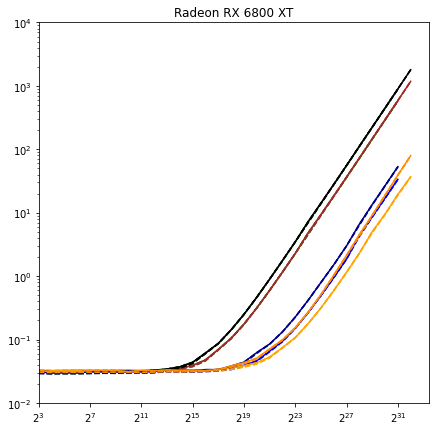

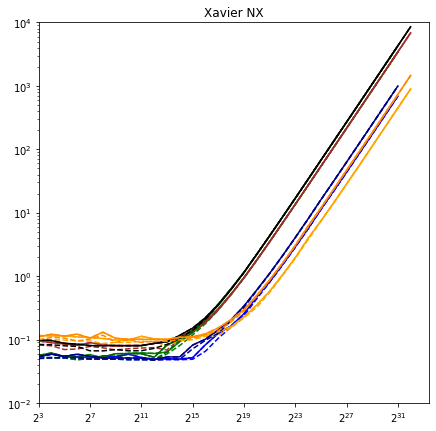

In [30]:
generatedCreatePlots(genStat)

In [31]:
genStat = generatedMakeStatistics('MappingLetter')
genStat

timeTransferToDevice  \
                                                                                                        min   
device            uniformInput inputLengthInCharacters kernel                                                 
Radeon RX 6800 XT False        8                       histogram_atomic_global                     0.020600   
                                                       histogram_atomic_global_stride              0.021000   
                                                       histogram_atomic_private                    0.016960   
                                                       histogram_atomic_private_stride             0.019000   
                               16                      histogram_atomic_global                     0.019840   
...                                                                                                     ...   
Xavier NX         True         2147483648              histogram_atomic_global_stride            278.799072   
                                                       histogram_atomic_private                  278.367798   
                                                       histogram_atomic_private_stride           278.711395   
                               4294967296              histogram_atomic_global_stride            559.324280   
                                                       histogram_atomic_private_stride           559.238525   

                                                                                                    \
                                                                                               q10   
device            uniformInput inputLengthInCharacters kernel                                        
Radeon RX 6800 XT False        8                       histogram_atomic_global            0.023485   
                                                       histogram_atomic_global_stride     0.023165   
                                                       histogram_atomic_private           0.023397   
                                                       histogram_atomic_private_stride    0.023063   
                               16                      histogram_atomic_global            0.023994   
...                                                                                            ...   
Xavier NX         True         2147483648              histogram_atomic_global_stride   279.241837   
                                                       histogram_atomic_private         278.990210   
                                                       histogram_atomic_private_stride  278.951056   
                               4294967296              histogram_atomic_global_stride   559.982336   
                                                       histogram_atomic_private_stride  560.084564   

                                                                                                    \
                                                                                               med   
device            uniformInput inputLengthInCharacters kernel                                        
Radeon RX 6800 XT False        8                       histogram_atomic_global            0.025485   
                                                       histogram_atomic_global_stride     0.025176   
                                                       histogram_atomic_private           0.025486   
                                                       histogram_atomic_private_stride    0.024810   
                               16                      histogram_atomic_global            0.026185   
...                                                                                            ...   
Xavier NX         True         2147483648              histogram_atomic_global_stride   279.909531   
                                                       histogram_atomic_private    

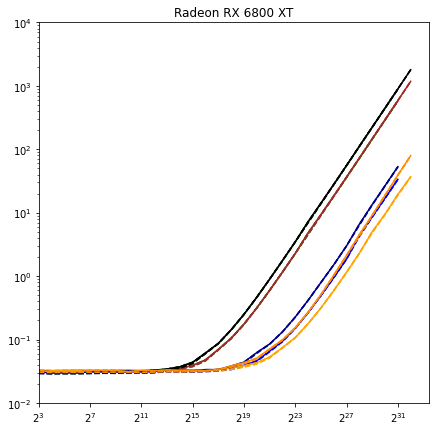

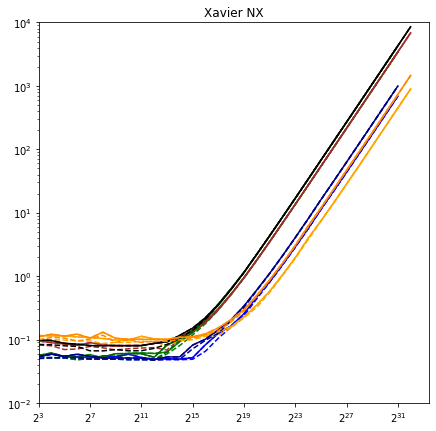

In [32]:
generatedCreatePlots(genStat)